# DineSafe Toronto: Exploratory Data Analysis (EDA)

This notebook explores restaurant inspection data from the City of Toronto's DineSafe program.

## Data Download Instructions

Before running this notebook, ensure the latest DineSafe dataset is available in `data/raw/`. To download the dataset:

```bash
python src/download_data.py
```

This will:
* Fetch metadata for the package from Toronto's Open Data portal
* Automatically find the latest available resources
* Save the CSV with a timestamped filename to `data/raw/`

Once the data is saved, this notebook will automatically detect and load the most recent file.

## Load the latest raw DineSafe CSV Data


(generated using the `download_data.py` script)

In [2]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
RAW_DIR = PROJECT_ROOT / "data" / "raw"

csv_files = list(RAW_DIR.glob("dinesafe_*.csv")) # finds all files matching this pattern

if not csv_files:
    raise FileNotFoundError(f"No raw DineSave CSV files found in {RAW_DIR.resolve()}") # .resolve() shows the absolute path

latest_file = max(csv_files, key=lambda f: f.stat().st_mtime) # sort by last modified time, then pick the latest

print(f"Loading {latest_file.name}")
df = pd.read_csv(latest_file)

Loading dinesafe_20250606_120907.csv


## Data Cleaning

We'll first inspect the data for any:
* Wrong data types
* Missing values
* Inconsistent category labels
* Duplicate rows

and then perform the necessary actions on the data.

## Initial Data Inspection

In [3]:
# Count the amount of non-null values in each column, and get their respective data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129695 entries, 0 to 129694
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   _id                        129695 non-null  int64  
 1   Establishment ID           129695 non-null  int64  
 2   Inspection ID              127150 non-null  float64
 3   Establishment Name         129695 non-null  object 
 4   Establishment Type         129695 non-null  object 
 5   Establishment Address      129695 non-null  object 
 6   Establishment Status       129695 non-null  object 
 7   Min. Inspections Per Year  129695 non-null  object 
 8   Infraction Details         80635 non-null   object 
 9   Inspection Date            127150 non-null  object 
 10  Severity                   80635 non-null   object 
 11  Action                     80635 non-null   object 
 12  Outcome                    425 non-null     object 
 13  Amount Fined               29

In [4]:
# Gets the total amount of null values in each column, sorted in descending order

df.isnull().sum().sort_values(ascending=False)

Amount Fined                 129398
Outcome                      129270
Infraction Details            49060
Action                        49060
Severity                      49060
Inspection Date                2545
Inspection ID                  2545
Longitude                         0
Latitude                          0
_id                               0
Establishment ID                  0
Min. Inspections Per Year         0
Establishment Status              0
Establishment Address             0
Establishment Type                0
Establishment Name                0
unique_id                         0
dtype: int64

In [5]:
# Calculates the percentage of the `Amount Fined` column that's null

df['Amount Fined'].isnull().sum()/len(df)

np.float64(0.9977100119511161)

In [6]:
# Calculates the percentage of the `Outcome` column that's null

df['Amount Fined'].isnull().mean()

np.float64(0.9977100119511161)

In [7]:
# Calculates the percentage of the 'Infraction Details' column that's null

df['Infraction Details'].isnull().mean()

np.float64(0.3782720999267512)

In [8]:
# Counts the different values we have for the 'Outcome' column

df.groupby('Outcome').Outcome.count()

Outcome
Cancelled                           17
Charges Withdrawn                   20
Conviction - Fined                 261
Conviction - Suspended Sentence      1
Pending                            126
Name: Outcome, dtype: int64

In [9]:
# Counts any duplicate rows

df.duplicated().sum()

np.int64(0)

### Key Findings
- No duplicate rows found
- All the rows have the majority of key columns complete, such as `Latitude`, `Longitude` (great for some mapping), `_id`, `Establishment ID`, etc.
- `Amount Fined`: 99.8% missing - likely only used when fines are issued
- 'Outcome' column is 99.8% missing, but has 5 distinct values:
    - Most frequent: **Conviction - Fined** (261 cases)
    - Others: Cancelled, Charges Withdrawn, Conviction - Suspended Sentence, Pending
- Might consider moving the two sparsely populated columns to their own feature group
- `Inspection Date` is not in DateTime format
- `Inspection ID` is stored as a float, likely should be integer

## Cleaning Plan

- Convert columns to correct types
- Handle missing values (perhaps impute)
- Normalize names
- Possibly drop sparse columns (likely not useful for EDA, but rather a targeted legal analysis)

## Cleaning Operations

We now apply the changes based on our inspection.

In [10]:
# Convert types
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
df['Inspection ID'] = df['Inspection ID'].astype('Int64')

# Normalize text
df['Establishment Type'] = df['Establishment Type'].str.strip().str.title()

# Drop low-value columns (temporarily)
# df = df.drop(columns=['Outcome', 'Amount Fined'])
# Not dropping these columns yet, but excluding from visualizations and analysis

# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129695 entries, 0 to 129694
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   _id                        129695 non-null  int64         
 1   Establishment ID           129695 non-null  int64         
 2   Inspection ID              127150 non-null  Int64         
 3   Establishment Name         129695 non-null  object        
 4   Establishment Type         129695 non-null  object        
 5   Establishment Address      129695 non-null  object        
 6   Establishment Status       129695 non-null  object        
 7   Min. Inspections Per Year  129695 non-null  object        
 8   Infraction Details         80635 non-null   object        
 9   Inspection Date            127150 non-null  datetime64[ns]
 10  Severity                   80635 non-null   object        
 11  Action                     80635 non-null   object  

In [37]:
# Save the cleaned data
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
output_path = PROCESSED_DIR / latest_file.name
df.to_csv(output_path, index=False)

## Exploratory Data Analysis (EDA)

Now that the data is cleaned, we can begin exploring trends and distributions in inspection data.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

### How many inspections are conducted per month?

In [12]:
# Filter DataFrame for inspections from the past year and a half
df_recent = df[df["Inspection Date"] >= (pd.Timestamp.now() - pd.DateOffset(months=12))]
df_recent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42348 entries, 85303 to 129694
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   _id                        42348 non-null  int64         
 1   Establishment ID           42348 non-null  int64         
 2   Inspection ID              42348 non-null  Int64         
 3   Establishment Name         42348 non-null  object        
 4   Establishment Type         42348 non-null  object        
 5   Establishment Address      42348 non-null  object        
 6   Establishment Status       42348 non-null  object        
 7   Min. Inspections Per Year  42348 non-null  object        
 8   Infraction Details         27148 non-null  object        
 9   Inspection Date            42348 non-null  datetime64[ns]
 10  Severity                   27148 non-null  object        
 11  Action                     27148 non-null  object        
 12  Outc

In [13]:
# Count the values in each YYYY-MM date
df_recent['Inspection Date'].dt.to_period("M").value_counts() # '2000-03-31 00:00:00' -> '2000-03'

Inspection Date
2024-11    4700
2024-10    4503
2025-04    4189
2024-08    4081
2025-03    3949
2024-07    3889
2025-05    3798
2025-01    3365
2024-12    3109
2024-09    3020
2025-02    3008
2025-06     737
Freq: M, Name: count, dtype: int64

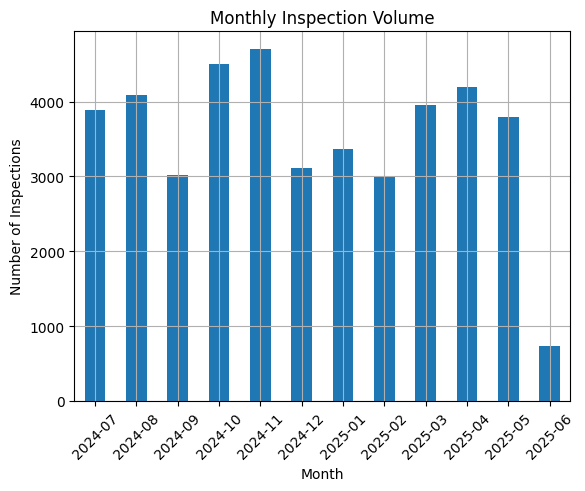

In [14]:
df_recent['Inspection Date'].dt.to_period("M").value_counts().sort_index().plot.bar()
plt.ylabel("Number of Inspections")
plt.xlabel("Month")
plt.title("Monthly Inspection Volume")
plt.grid(True, which='both', axis='both')
plt.xticks(rotation=45)
plt.show()

### Are there seasonal patterns?

In [15]:
# Count the number of values for each month
df['Inspection Date'].dt.month.value_counts()

Inspection Date
3.0     12438
4.0     12170
11.0    11940
10.0    11429
8.0     11117
5.0     10772
2.0     10652
7.0     10196
1.0      9816
6.0      9280
9.0      8863
12.0     8477
Name: count, dtype: int64

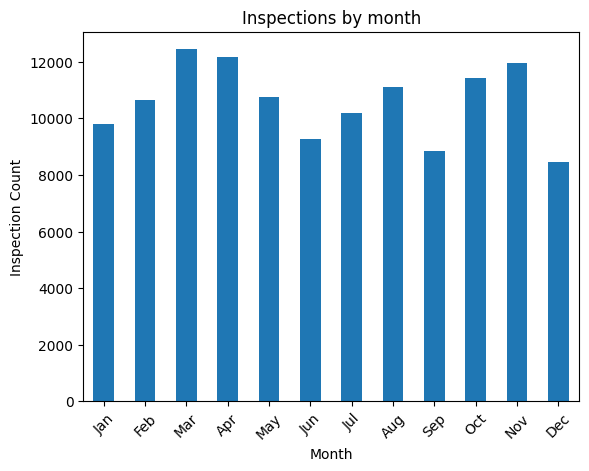

In [16]:
ax = df['Inspection Date'].dt.month.value_counts().sort_index().plot.bar()
plt.title("Inspections by month")
plt.xlabel("Month")
plt.ylabel("Inspection Count")

month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.set_xticklabels(month_names, rotation=45)
plt.show()

### What are the most common establishment types?

In [17]:
df["Establishment Type"].value_counts().nlargest(15).sort_values(ascending=False)

Establishment Type
Restaurant                          65444
Food Take Out                       21883
Food Store (Convenience/Variety)     6261
Food Court Vendor                    4534
Supermarket                          4209
Child Care - Catered                 3358
Bakery                               3268
Child Care - Food Preparation        2429
Student Nutrition Site               1284
Food Caterer                         1226
Retirement Homes(Licensed)           1164
Butcher Shop                         1128
Food Processing Plant                1127
Banquet Facility                     1124
Community Kitchen (Meal Program)      892
Name: count, dtype: int64

### What are the most inspected establishment names?

In [18]:
df["Establishment Name"].value_counts().nlargest(15).sort_values(ascending=False)

Establishment Name
TIM HORTONS                  1976
SUBWAY                       1008
PIZZA PIZZA                   614
MCDONALD'S                    389
STARBUCKS                     363
SHOPPERS DRUG MART            291
FRESHII                       268
PIZZAIOLO                     247
A & W                         229
METRO                         226
POPEYES LOUISIANA KITCHEN     225
PIZZA NOVA                    223
BOOSTER JUICE                 217
THAI EXPRESS                  212
MONKEY SUSHI                  210
Name: count, dtype: int64

### What are the most inspected establishments?

In [19]:
inspection_counts = df.groupby("Establishment ID").size().reset_index(name="Inspection Count")
establishment_names = df.groupby("Establishment ID")["Establishment Name"].first().reset_index() # Assuming name doesn't vary
inspection_summary = pd.merge(inspection_counts, establishment_names, on="Establishment ID").sort_values("Inspection Count", ascending=False)

inspection_summary.head(20)


,Establishment ID,Inspection Count,Establishment Name
6112,10493439,90,LUCKY DRAGON RESTAURANT
6145,10495233,86,COMMISSO BROS & RACCO ITALIAN BAKERY
9535,10636932,69,TERRA NOVA BAKERY AND PASTRY
15274,10775371,66,THE BIRYANI WALLA
12395,10735040,64,MB THE PLACE TO BE
10773,10681043,59,PHO ANH VU
279,9002879,56,CHINA GOURMET
5677,10472630,55,Kairali
13199,10752854,54,CHIANG RAI
8148,10582617,54,MAINSHA RESTAURANT


### Are certain establishment types associated with higher mandated inspection frequencies?

In [20]:
df["Min. Inspections Per Year"] = pd.to_numeric(df["Min. Inspections Per Year"], errors="coerce")
avg_min_inspections_by_type = df.groupby("Establishment Type")["Min. Inspections Per Year"].mean().sort_values(ascending=False)
avg_min_inspections_by_type.head(20)


Establishment Type
Milk Pasteurization Plant             3.000000
Retirement Homes(Un-Licensed)         3.000000
Retirement Homes(Licensed)            3.000000
Nursing Home / Home For The Aged      3.000000
Hospitals & Health Facilities         2.954155
Centralized Kitchen                   2.947368
Institutional Food Services           2.806397
Rest Home                             2.800000
Food Caterer                          2.740620
Child Care - Food Preparation         2.639358
Banquet Facility                      2.626002
Boarding / Lodging Home - Kitchen     2.571843
Catering Vehicle                      2.565217
Restaurant                            2.480598
Food Court Vendor                     2.441112
Commissary                            2.317254
College / University Food Services    2.308411
Bakery                                2.296206
Flea Market                           2.288660
Serving Kitchen                       2.286096
Name: Min. Inspections Per Year, dtype: f

In [21]:
avg_min_inspections_by_type.tail(20)

Establishment Type
Ice Cream / Yogurt Vendors                  1.946154
Other Educational Facility Food Services    1.945455
Elementary School Food Services             1.928571
Fish Shop                                   1.865385
Food Vending Facility                       1.829787
Meat Processing Plant                       1.826087
Fairs / Festivals / Special Occasions       1.807229
Cocktail Bar / Beverage Room                1.796552
Bed & Breakfast                             1.777778
Refreshment Stand (Stationary)              1.734513
Ice Manufacturing Plant                     1.600000
Ice Cream Plant                             1.600000
Food Bank                                   1.469027
Student Nutrition Site                      1.450156
Locker Plant                                1.400000
Food Store (Convenience/Variety)            1.389828
Food Depot                                  1.262260
Brew Your Own Beer / Wine                   1.235294
Milk Products Plant        

**Higher-Risk, More Frequently Inspected Categories**:
- Milk Pasteurization Plant, Retirement Homes, Nursing Home, Hospitals, Child Care, Catering, Restaurant, College
- These facilities serve vulnerable populations (e.g. elderly or hospitalized), or handle high-risk food (like raw milk or bulk food prep)

**Lower-Risk, Less Frequently Inspected Categories**:
- Ice Cream Vendors, Farmers' Market Vendor, Food Vending Facility, Meat Processing Plant
- Primarily handle packaged or frozen goods
- Prepare low-risk foods with minimal handling

### How are inspections distributed across the city?

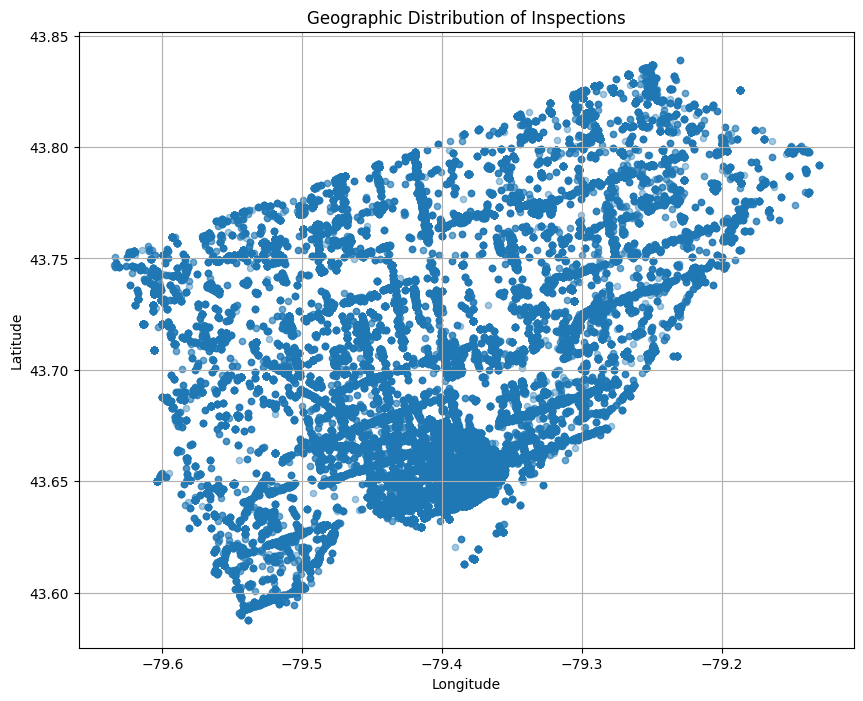

In [30]:
df.plot.scatter(x="Longitude", y="Latitude", alpha=0.4, figsize=(10,8))

plt.title("Geographic Distribution of Inspections")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


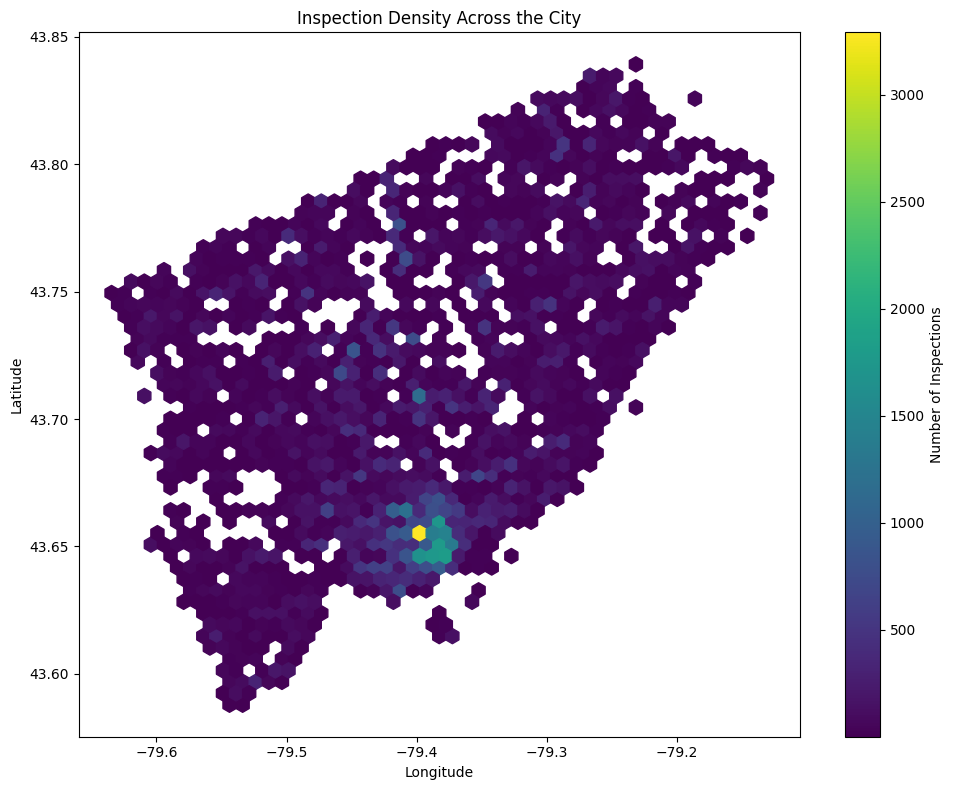

In [23]:
plt.figure(figsize=(10, 8))
plt.hexbin(df["Longitude"], df["Latitude"], gridsize=50, cmap="viridis", mincnt=1)

plt.title("Inspection Density Across the City")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Number of Inspections")
plt.tight_layout()
plt.show()
